### Dataset Labeler

This notebook is used to label a raw fake dataset.

In [1]:
from pathlib import Path
import re
import sys
from collections import namedtuple
import random
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Plotting options for notebook
%matplotlib notebook
import matplotlib.pyplot as plt

# Add local directories to path, get dataset utils
ROOT_DIR = Path.cwd()
sys.path.append(str(ROOT_DIR))

from data_utils import load_image_ndarray, plot_image

## Load Images

In [4]:
def mask(image_path, default_color=(255, 0, 255)):
    """
    Gets the mask for a given synthetic image
    :param image_path: (Path) image path
    :param default_color: (3-tuple) default or "green-screen" color
    :return: (ndarray) binary mask (one channel)
    """
    # Need the image in ndarray form to get the mask
    image = load_image_ndarray(image_path)
    # Change default color pixels to zero
    image[np.where((image == default_color).all(axis=2))] = [0, 0, 0]
    # Create the mask and change all other pixels to 1
    mask = np.copy(image[:, :, 0])
    mask[np.where((image != 0).all())] = 1
    return mask


def _add_background(image_path, default_color=(255, 0, 255)):
    # Need the image in ndarray form to get bounding box
    image = load_image_ndarray(image_path)
    pass

def add_background(image, room_image_path):
    
    background_img = Image.open(str(random.choice(room_image_path)))
    background_loader = transforms.Compose([
        transforms.RandomCrop(imsize)
    ])
    background_img = background_loader(background_img)
    background_img.paste(image)
    return background_img
    

<IPython.core.display.Javascript object>


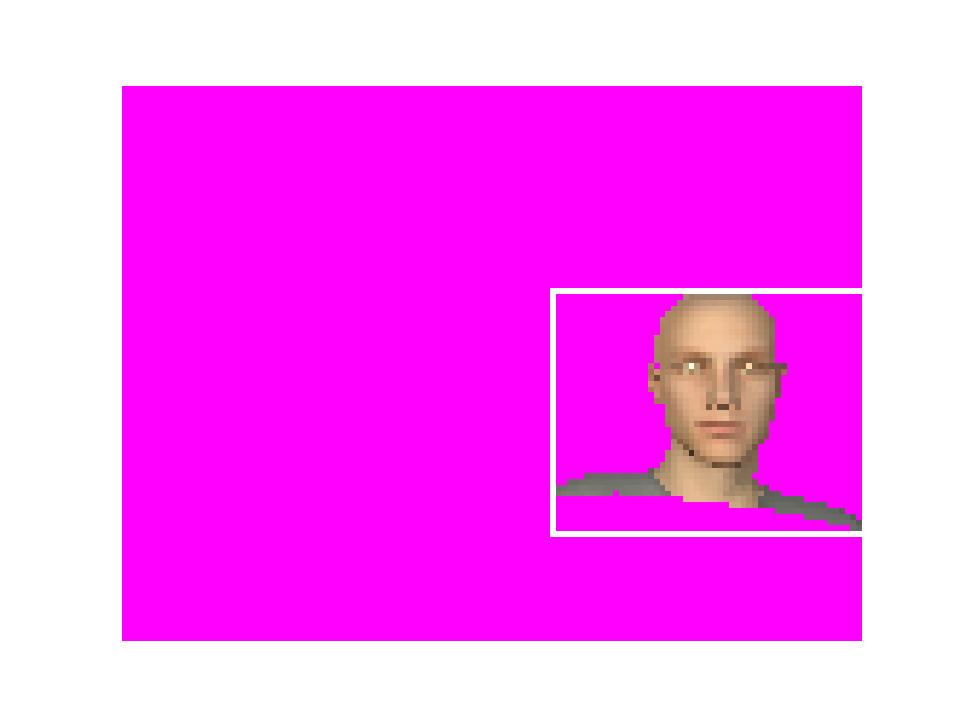

bounding box [74, 35, 128, 77]


<IPython.core.display.Javascript object>


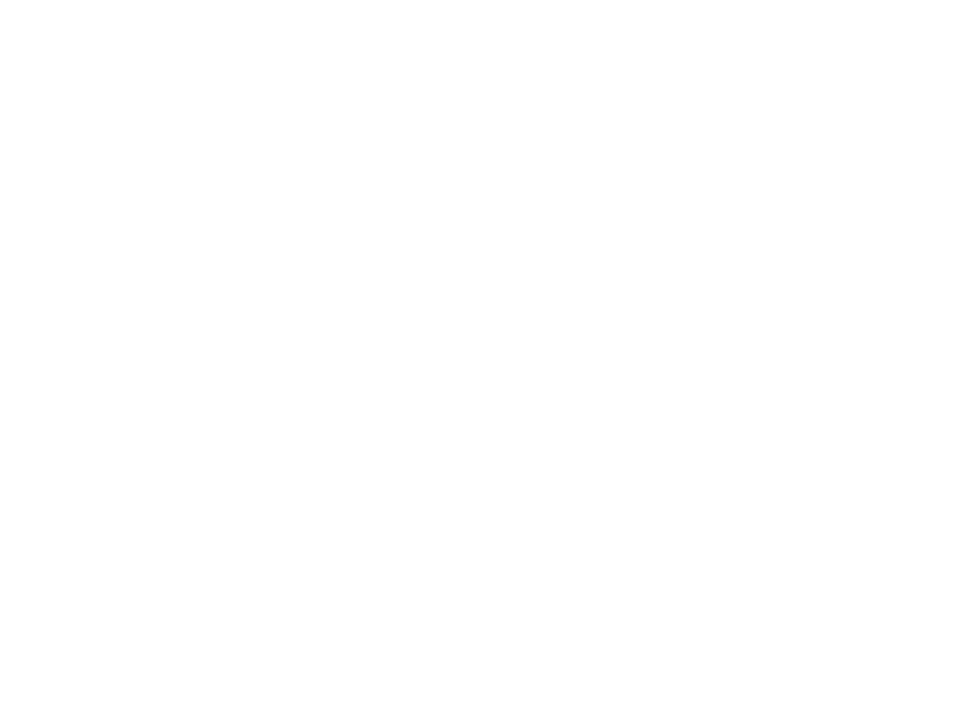

In [5]:
# Local dataset directory
data_dir = ROOT_DIR / '..' /  'data'

fake_dataset_path = data_dir / '26022018_0641'
room_dataset_path = data_dir / 'livingroom'

# grab random images
fake_image_path = str(list(fake_dataset_path.glob('*.png'))[0])
room_image_path = list(room_dataset_path.glob('*.jpg'))


fake_image, fake_image_tensor = load_single_image(fake_image_path, (96, 128), plot=True)

## Get bounding box from mask image